In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

In [2]:
labeled = pd.read_csv('../company_with_score.csv',index_col=0)
test_index = pd.read_csv('../Data/test_index.csv',index_col=0)
master = pd.read_csv('../master_data.csv',index_col=0)
master = master[master['CompanyId'] != -999999]
# drop three columns (all 0)
master.drop(columns=['USAGE_APP10_SYSCOUNT','USAGE_FEAT10_SYSCOUNT','ProductFamily_B_count','ProductFamily_D_Provider3_count'],inplace=True)
master.reset_index(drop=True,inplace=True)
labeled.reset_index(drop=True,inplace=True)
master['YearMonth'] = master['YearMonth'].astype('str')
master['recent'] = max(master['YearMonth'])

In [3]:
master['YearMonth'] = pd.to_datetime(master['YearMonth'],format='%Y%m')
master['recent'] = pd.to_datetime(master['recent'],format='%Y%m')
master['exponential'] = ((master['YearMonth'] - master['recent'])//np.timedelta64(1, 'M'))

In [4]:
labeled.rename(columns={'CompanyID':'CompanyId'},inplace=True)

### decaying function
$val = \sum \limits _{i=-44} ^{0} val_i*alpha^{i} $

In [5]:
alpha = 1.1

In [6]:
denominator = 0
for i in range(-44,1):
    denominator += alpha**i

In [7]:
def decaying(alpha, company_id, df):
    row = [company_id]
    df_comp = df[df['CompanyId']==company_id]
    for col in df.columns[2:-2]:
        fin_val = 0
        for val, power in zip(df_comp[col].values, df_comp['exponential'].values):
            fin_val += val*(alpha**power)
        row.append(fin_val/denominator)
    return row

100%|██████████████████████████████████████| 7345/7345 [00:41<00:00, 177.49it/s]


<AxesSubplot:>

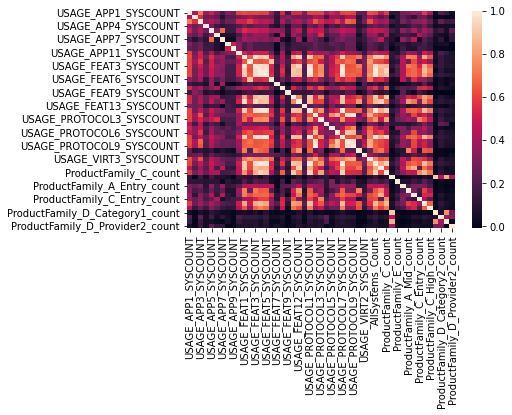

In [8]:
weighted_master = pd.DataFrame(columns=master.columns)
weighted_master.drop(columns=['YearMonth','recent', 'exponential'], inplace=True)
company_ids = master['CompanyId'].value_counts().index
for company_id in tqdm(company_ids):
    weighted_master.loc[len(weighted_master.index)] = decaying(alpha, company_id, master)
weighted_master['CompanyId'] = weighted_master['CompanyId'].astype('int64')
sns.heatmap(weighted_master[weighted_master.columns[1:]].corr())

### average (count period with no records in)
CompanyId | period | col1
---:|:---:| ---
123456 | 1 | 2
123456 | 2 | 0
123456 | 4 | 4
123456 | 6 | 3

averaged col1 = (2+4+3)/**6** = 1.5

In [9]:
deno_comp = master[['CompanyId','exponential']].groupby('CompanyId').min()['exponential']

In [10]:
def average(company_id, df):
    row = [company_id]
    df_comp = df[df['CompanyId']==company_id]
    for col in df.columns[2:-2]:
        val = sum(df_comp[col])/-(deno_comp[company_id]-1)
        row.append(val)
    return row

100%|██████████████████████████████████████| 7345/7345 [00:09<00:00, 754.63it/s]


<AxesSubplot:>

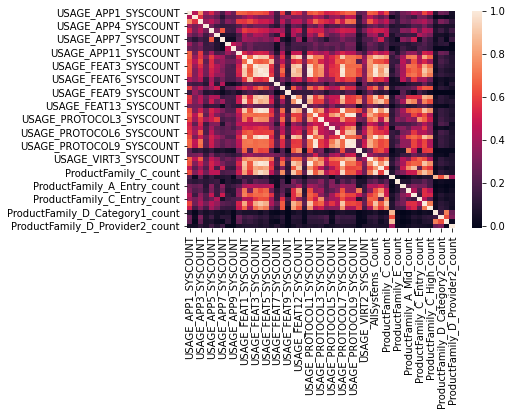

In [11]:
all_avg_master = pd.DataFrame(columns=master.columns)
all_avg_master.drop(columns=['YearMonth','recent', 'exponential'], inplace=True)
for company_id in tqdm(company_ids):
    all_avg_master.loc[len(all_avg_master.index)] = average(company_id, master)
all_avg_master['CompanyId'] = all_avg_master['CompanyId'].astype('int64')
sns.heatmap(all_avg_master[all_avg_master.columns[1:]].corr())

### non-zero average
CompanyId | period | col1
---:|:---:| ---
123456 | 1 | 2
123456 | 2 | 0
123456 | 4 | 4
123456 | 6 | 3

averaged col1 = (2+4+3)/**3** = 3

In [12]:
def non_zero_average(company_id, df):
    row = [company_id]
    df_comp = df[df['CompanyId']==company_id]
    for col in df.columns[2:-2]:
        cnt = 0
        tmp_sum = 0
        for i in df_comp[col].values:
            if i != 0:
                cnt += 1
                tmp_sum += i
        if cnt != 0:
            row.append(tmp_sum/cnt)
        else:
            row.append(0)
    return row

100%|██████████████████████████████████████| 7345/7345 [00:11<00:00, 667.51it/s]


<AxesSubplot:>

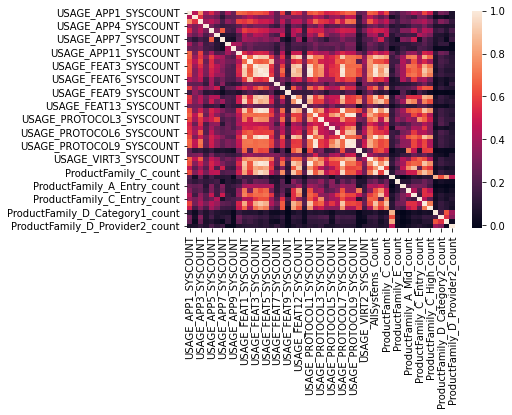

In [13]:
existed_avg_master = pd.DataFrame(columns=master.columns)
existed_avg_master.drop(columns=['YearMonth','recent', 'exponential'], inplace=True)
for company_id in tqdm(company_ids):
    existed_avg_master.loc[len(existed_avg_master.index)] = non_zero_average(company_id, master)
existed_avg_master['CompanyId'] = existed_avg_master['CompanyId'].astype('int64')
sns.heatmap(existed_avg_master[existed_avg_master.columns[1:]].corr())

In [14]:
weighted_master=weighted_master.merge(labeled,on='CompanyId')

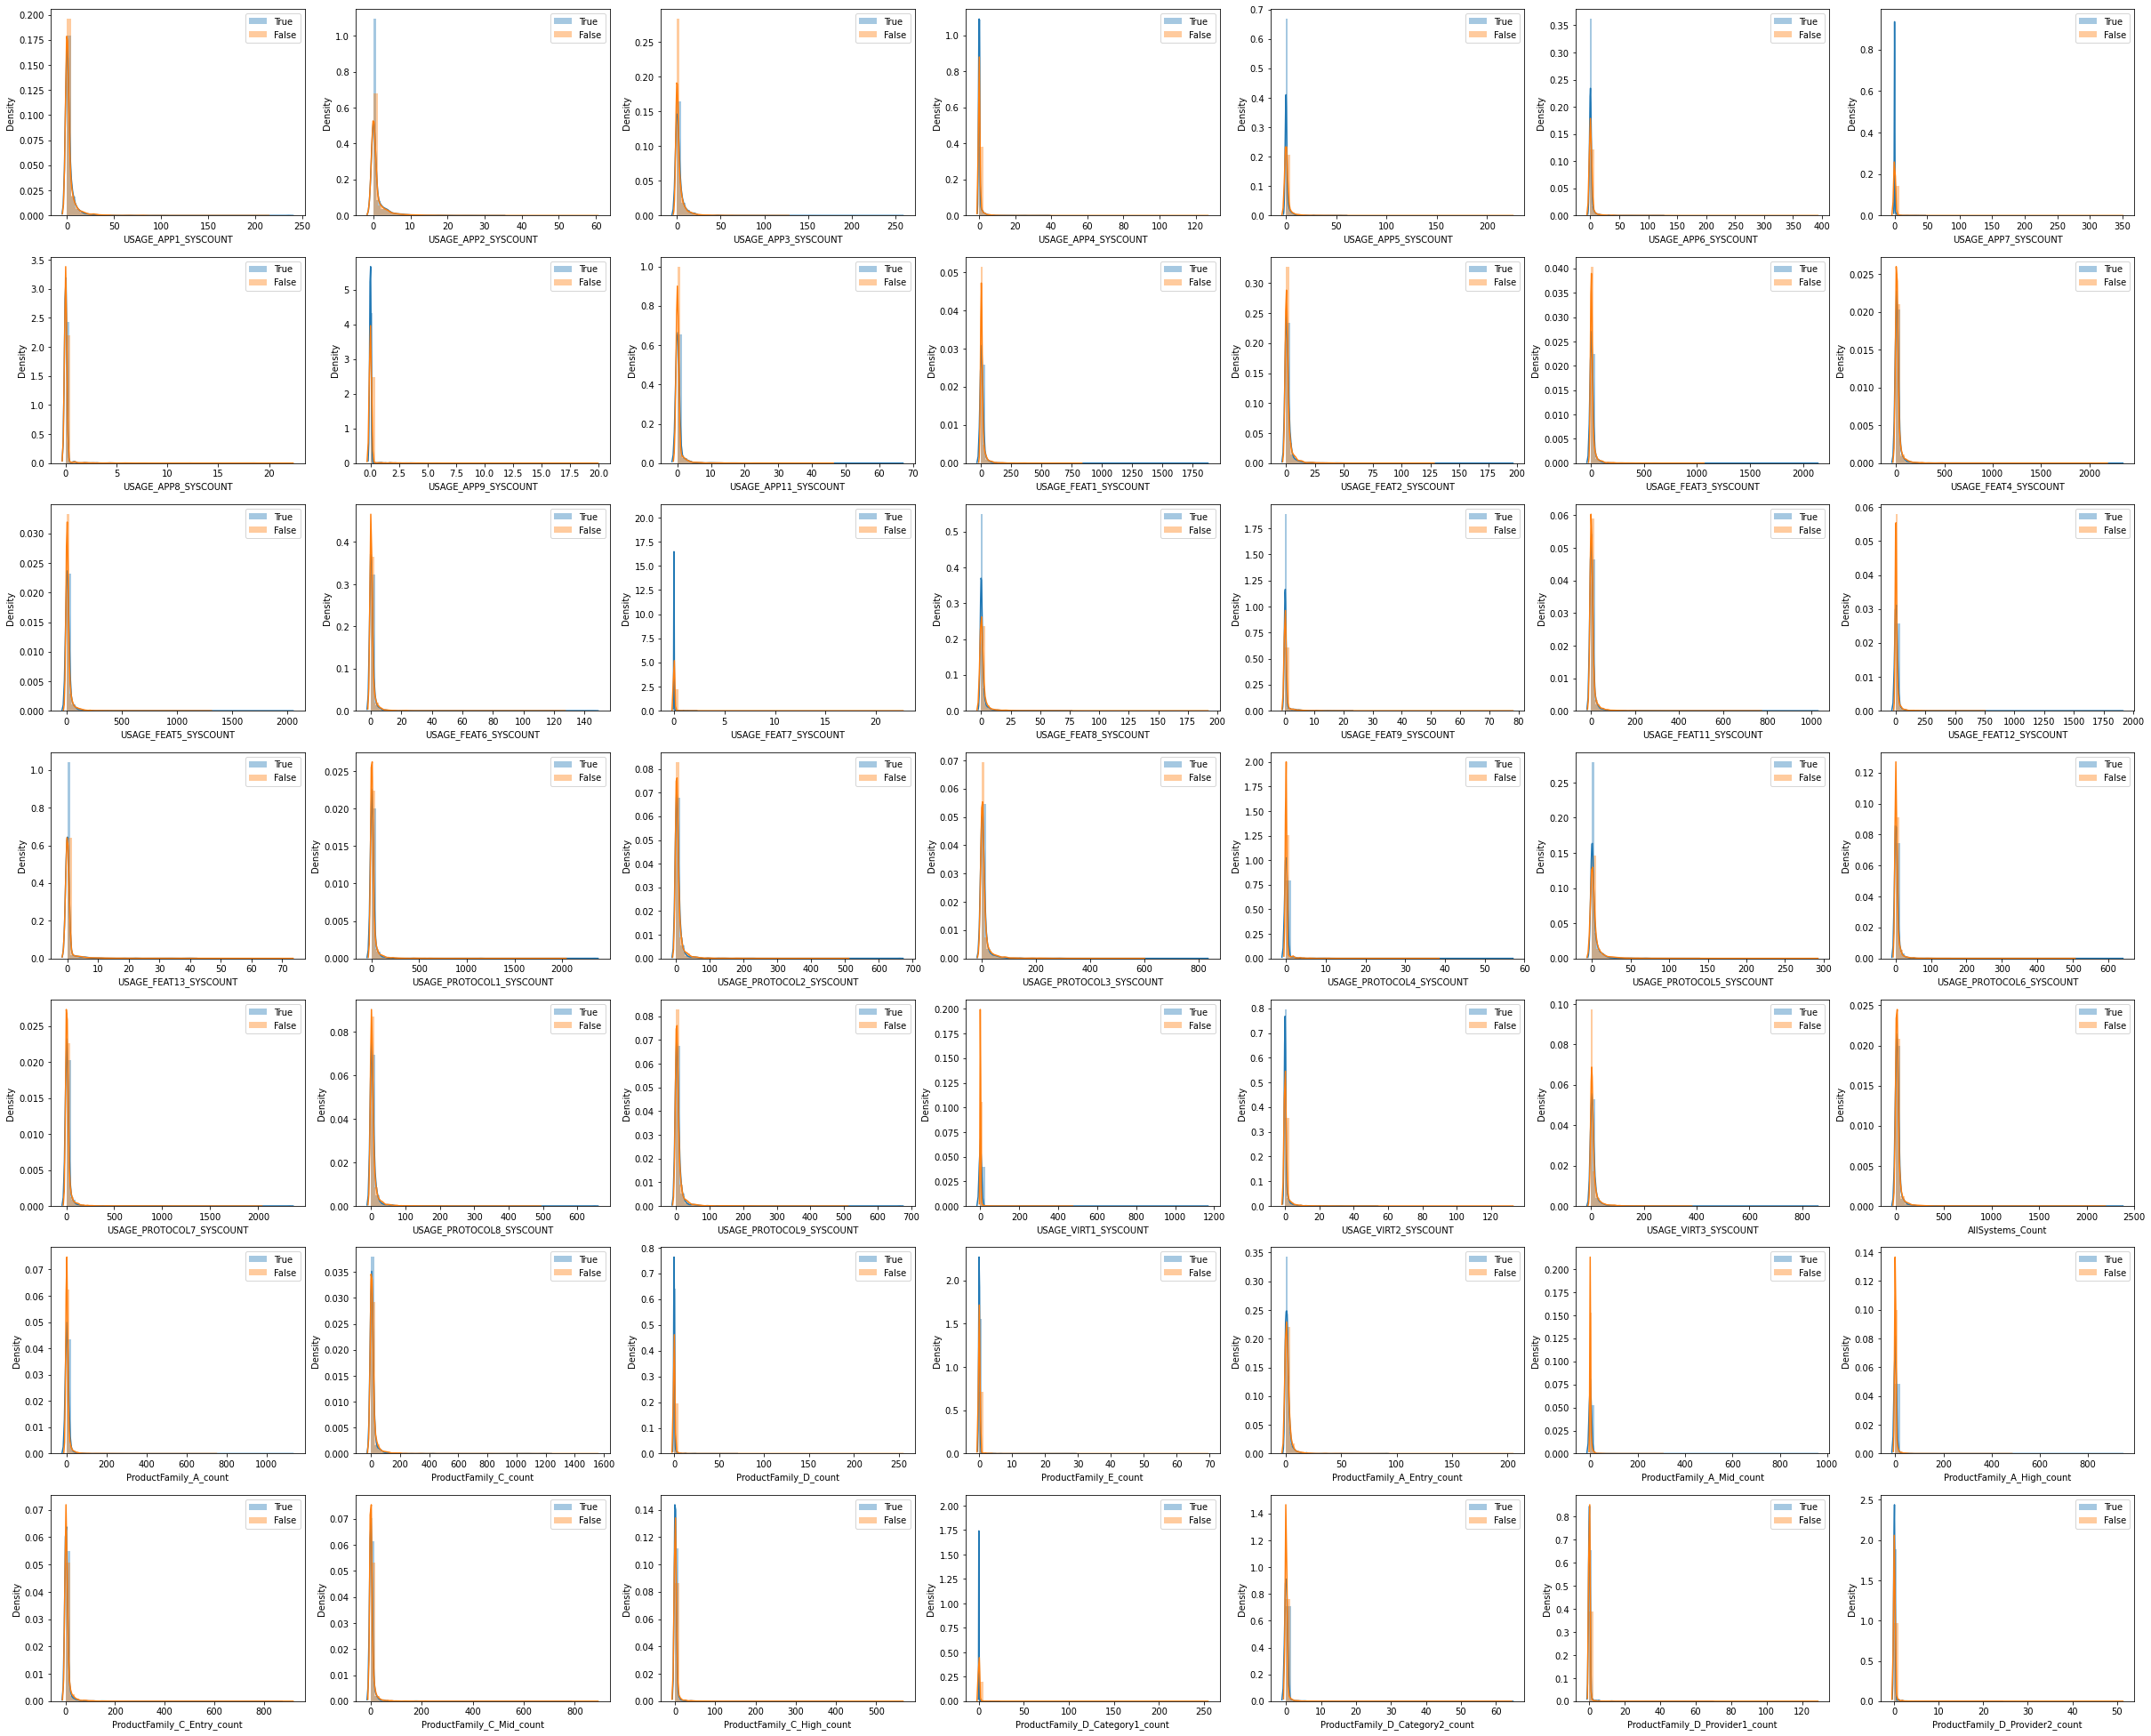

In [15]:
f, axs = plt.subplots(7,7,figsize=(42, 35))
for idx, col in enumerate(weighted_master.columns[1:-2]):
    sns.distplot(weighted_master[weighted_master['early_adopter'] == True][col], label='True', ax=axs[idx//7][idx%7])
    sns.distplot(weighted_master[weighted_master['early_adopter'] == False][col], label='False', ax=axs[idx//7][idx%7])
    axs[idx//7][idx%7].legend()

In [16]:
existed_avg_master=existed_avg_master.merge(labeled,on='CompanyId')

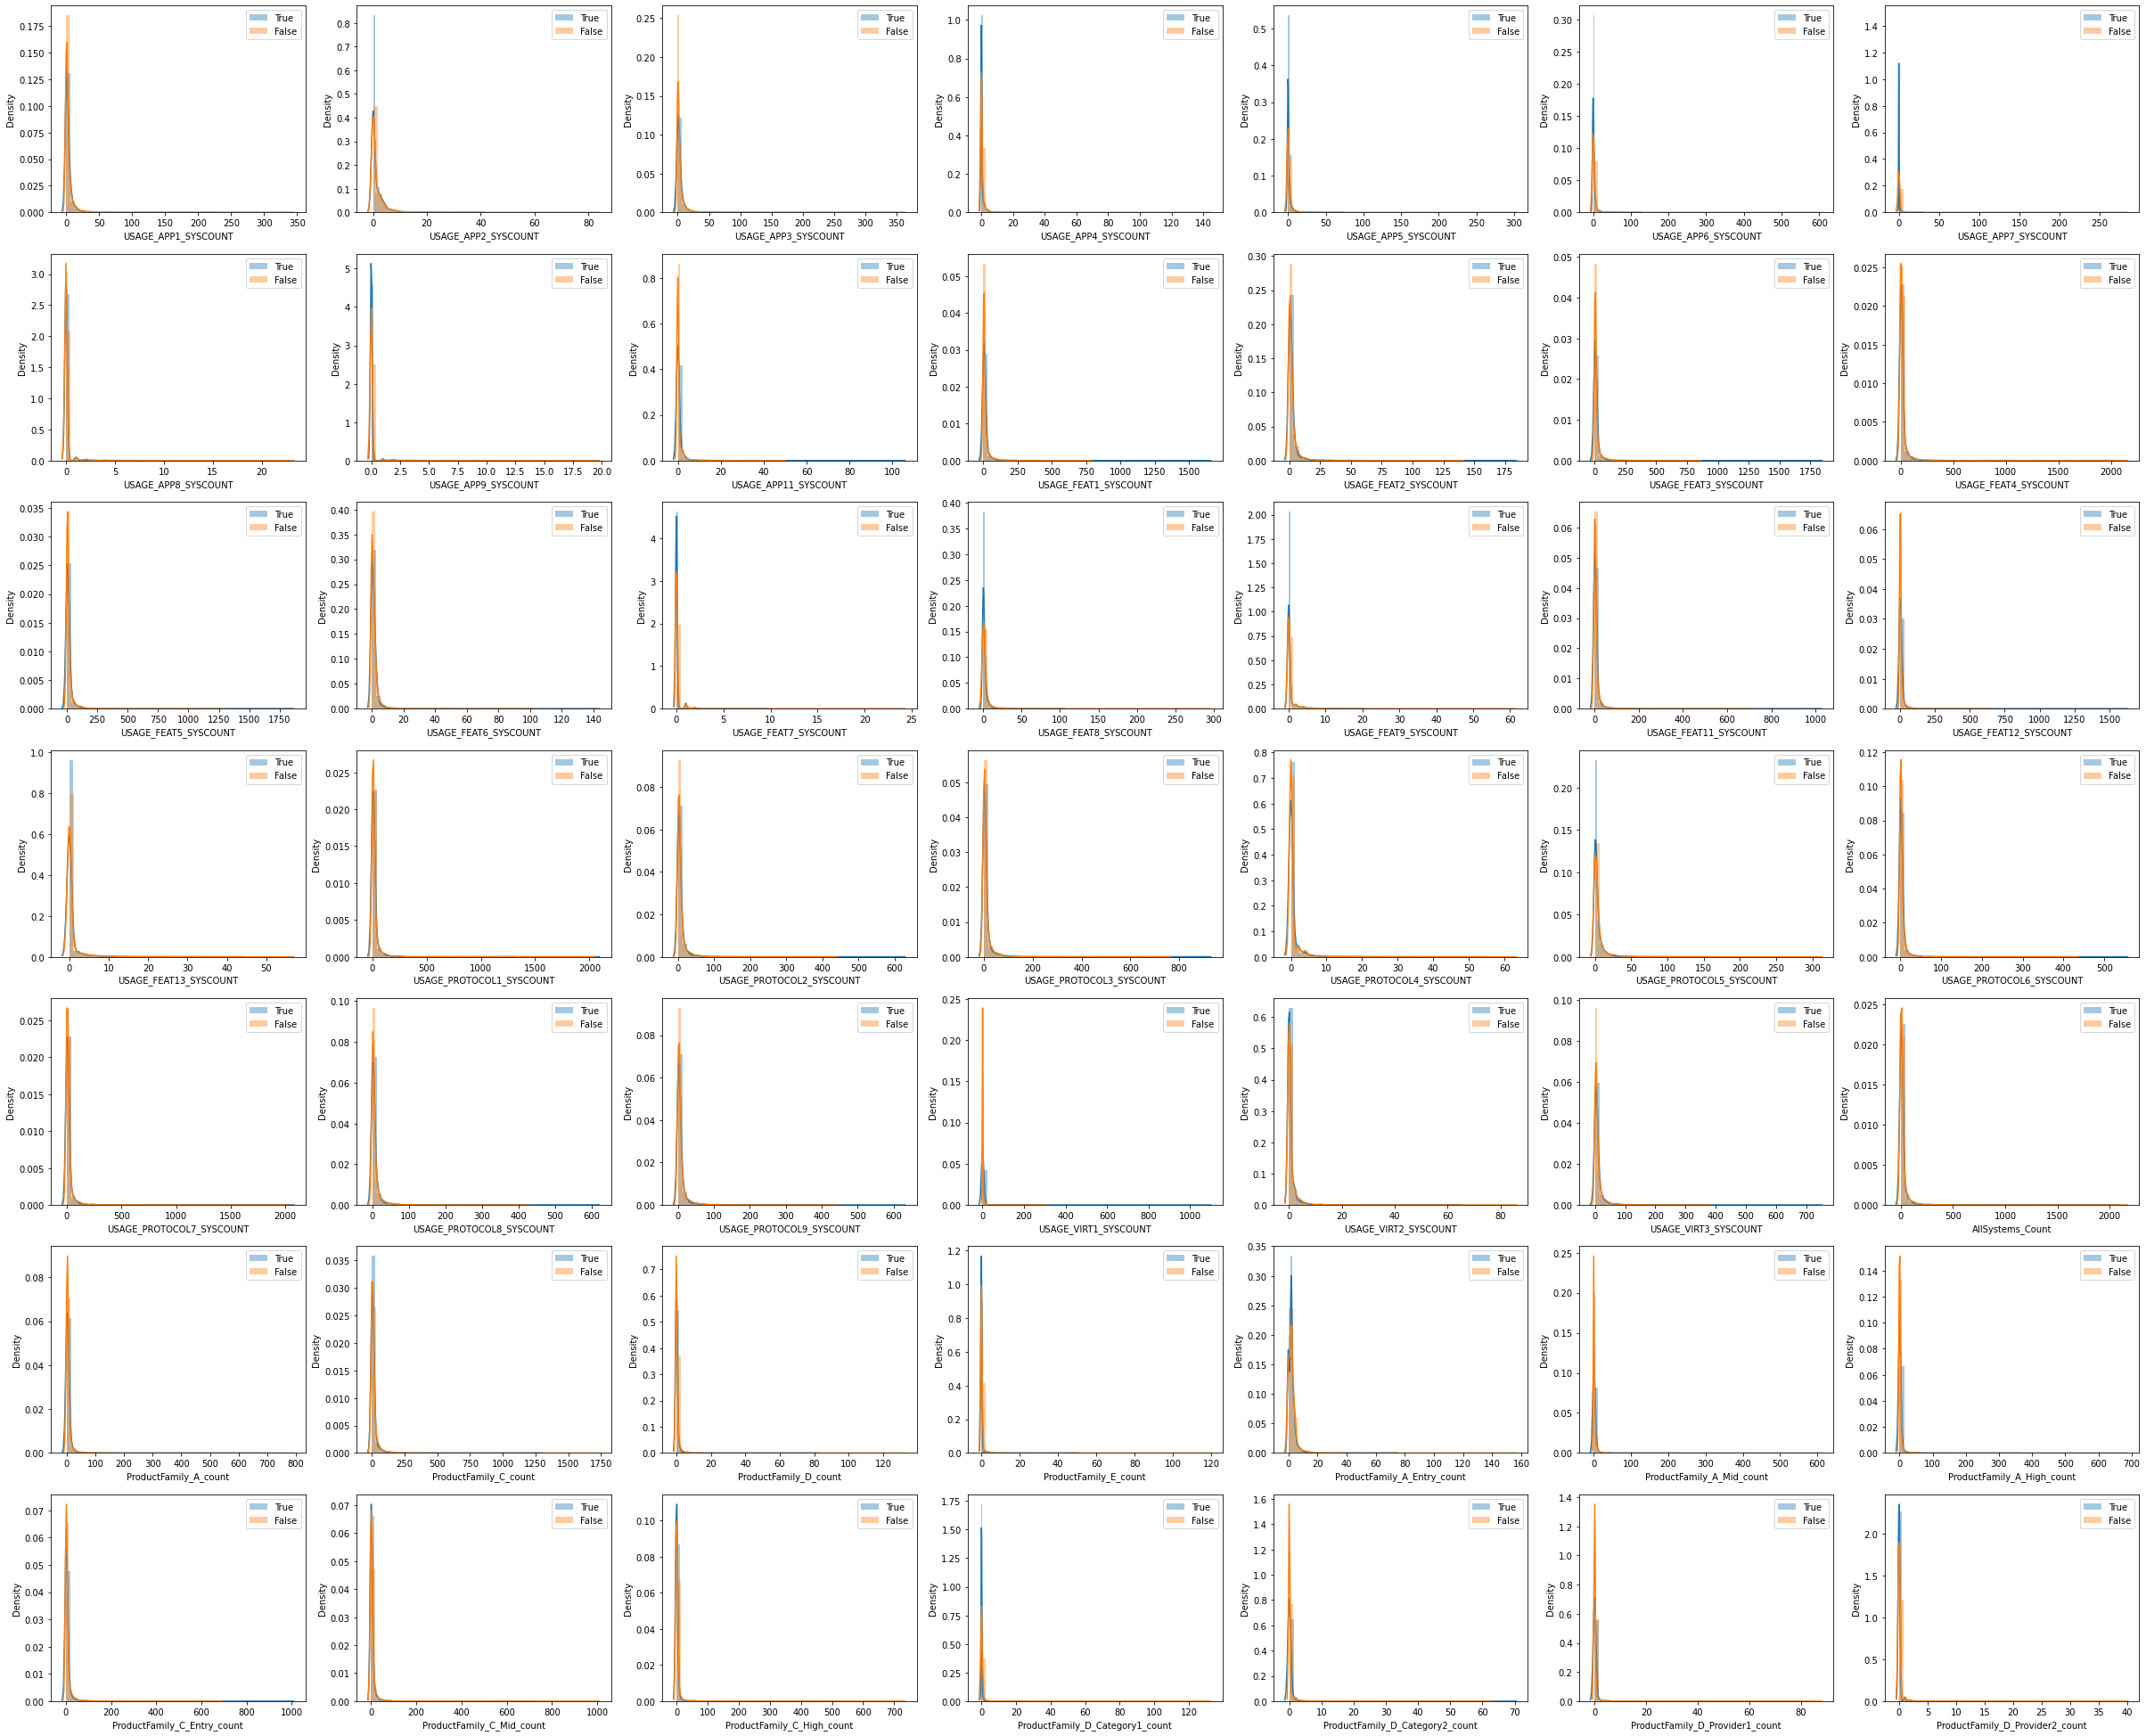

In [17]:
f, axs = plt.subplots(7,7,figsize=(42, 35))
for idx, col in enumerate(existed_avg_master.columns[1:-2]):
    sns.distplot(existed_avg_master[existed_avg_master['early_adopter'] == True][col], label='True', ax=axs[idx//7][idx%7])
    sns.distplot(existed_avg_master[existed_avg_master['early_adopter'] == False][col], label='False', ax=axs[idx//7][idx%7])
    axs[idx//7][idx%7].legend()

In [18]:
all_avg_master=all_avg_master.merge(labeled,on='CompanyId')

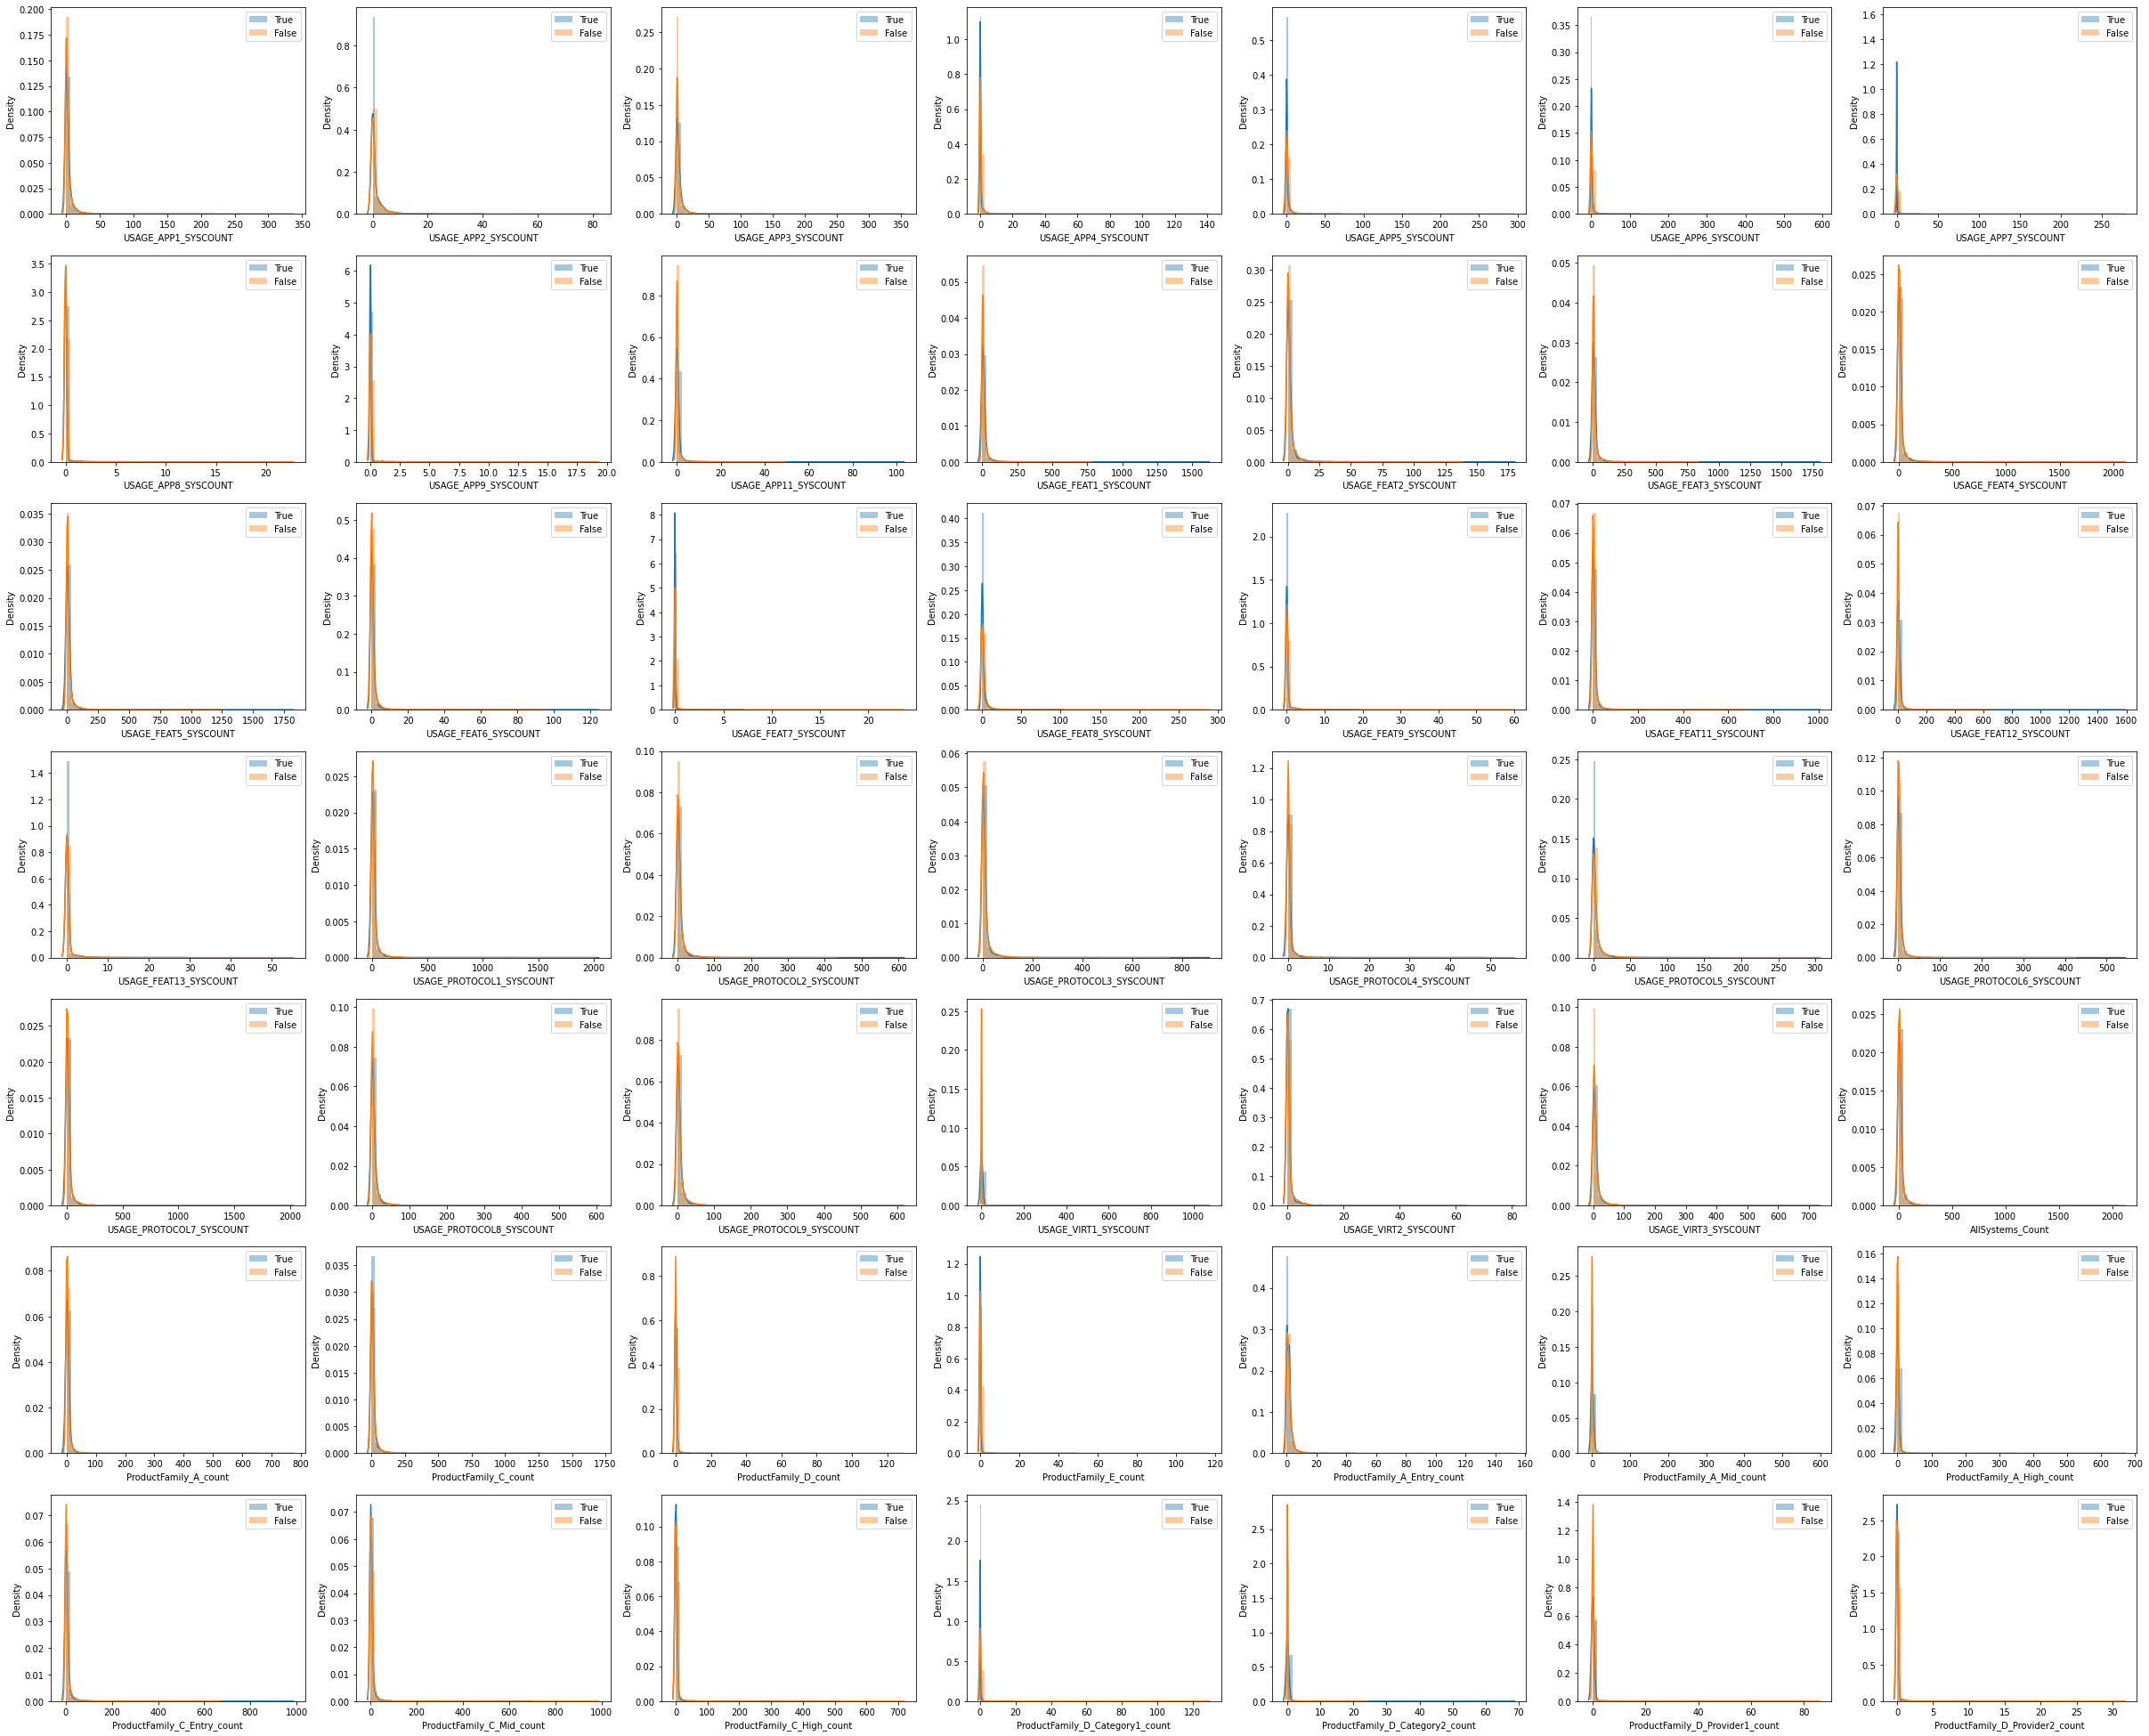

In [19]:
f, axs = plt.subplots(7,7,figsize=(42, 35))
for idx, col in enumerate(all_avg_master.columns[1:-2]):
    sns.distplot(all_avg_master[all_avg_master['early_adopter'] == True][col], label='True', ax=axs[idx//7][idx%7])
    sns.distplot(all_avg_master[all_avg_master['early_adopter'] == False][col], label='False', ax=axs[idx//7][idx%7])
    axs[idx//7][idx%7].legend()

#### running random forest on three datasets

In [20]:
all_avg_master['test'] = test_index['test']
existed_avg_master['test'] = test_index['test']
weighted_master['test'] = test_index['test']

In [21]:
def rf(data):
    train = data[data['test']==0]
    test = data[data['test']==1]
    Xtrain = train.loc[:,train.columns[1:-3]]
    ytrain = train['early_adopter']
    Xtest = test.loc[:,test.columns[1:-3]]
    ytest = test['early_adopter']
    lr = RandomForestClassifier(n_estimators=1000).fit(Xtrain, ytrain)
    return lr.score(Xtrain,ytrain), lr.score(Xtest,ytest), 1 - ytest.mean()

In [22]:
rf(all_avg_master)

(0.9996463306808134, 0.7050823192555477, 0.690050107372942)

In [23]:
rf(existed_avg_master)

(0.9959328028293546, 0.6964924838940587, 0.690050107372942)

In [24]:
rf(weighted_master)

(0.9996463306808134, 0.7301360057265569, 0.690050107372942)

In [25]:
X = weighted_master.loc[:,weighted_master.columns[1:-3]]
y = weighted_master['early_adopter']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
rf1 = RandomForestClassifier(n_estimators=1000).fit(Xtrain, ytrain)
rf1.score(Xtest,ytest)

0.7236215112321307

In [26]:
1-ytest.mean()

0.6950306330837304

In [27]:
feature_imp = pd.Series(rf1.feature_importances_,
       index=Xtrain.columns).sort_values(ascending=True)
feature_imp

USAGE_APP9_SYSCOUNT                0.001540
USAGE_APP8_SYSCOUNT                0.002004
ProductFamily_E_count              0.002331
ProductFamily_D_Provider2_count    0.003042
ProductFamily_D_Category1_count    0.003213
USAGE_FEAT7_SYSCOUNT               0.003407
ProductFamily_D_Category2_count    0.003420
USAGE_APP7_SYSCOUNT                0.004129
ProductFamily_D_Provider1_count    0.005011
ProductFamily_D_count              0.005914
ProductFamily_C_High_count         0.006517
USAGE_PROTOCOL4_SYSCOUNT           0.006577
USAGE_FEAT13_SYSCOUNT              0.006777
ProductFamily_A_High_count         0.007030
USAGE_APP4_SYSCOUNT                0.008068
USAGE_APP11_SYSCOUNT               0.008199
USAGE_FEAT9_SYSCOUNT               0.008248
USAGE_VIRT2_SYSCOUNT               0.010794
USAGE_APP5_SYSCOUNT                0.011288
USAGE_VIRT1_SYSCOUNT               0.013631
USAGE_APP6_SYSCOUNT                0.017075
USAGE_APP2_SYSCOUNT                0.017168
ProductFamily_A_Mid_count       

In [28]:
X = weighted_master.loc[:,('ProductFamily_A_Entry_count','ProductFamily_A_count')]
y = weighted_master['early_adopter']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
rf2 = RandomForestClassifier(n_estimators=1000).fit(Xtrain, ytrain)
print('Baseline:',1-ytest.mean())
rf2.score(Xtest,ytest)

Baseline: 0.6963921034717495


0.7052416609938734

In [29]:
feature_imp = pd.Series(rf2.feature_importances_,
       index=Xtrain.columns).sort_values(ascending=False)
feature_imp

ProductFamily_A_count          0.59679
ProductFamily_A_Entry_count    0.40321
dtype: float64